### SBERT

Dataset: "Amazon Reviews: Musical Instruments" from https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/

In [43]:
import json
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import torch
from transformers import RobertaTokenizer, RobertaModel
import tools as tl
import numpy as np


In [44]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="'force_all_finite' was renamed to 'ensure_all_finite'",
    category=FutureWarning,
)


### For Mac

In [45]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


### Defining Functions

In [46]:
def read_json_array(path):
  data = []
  with open(path, 'r') as file:
    for line in file:
      json_object = json.loads(line.strip())
      data.append(json_object)
  return data

### Loading dataset

In [47]:
dataset_path = '../datasets/amazon_reviews/'
data_path = dataset_path + "Musical_Instruments.json"

data = read_json_array(data_path)
# Extract relevant fields for processing
data_df = pd.DataFrame(data)
df = pd.DataFrame({})
df['text'] = data_df['reviewText']

In [48]:
len(df)

1512530

In [49]:
# Taking only first 1000 for demo 
df = df.head(15000)

### Creating Embeddings

In [52]:
# Initialize distilroberta tokenizer and model
df['text'] = df['text'].astype(str)

tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base')
model = RobertaModel.from_pretrained('distilroberta-base')
# Generate embeddings
print("Generating embeddings...")
embeddings = tl.generate_embeddings(df['text'].tolist(), tokenizer, model)
print("Embeddings generated!")

Generating embeddings...


Generating Embeddings: 100%|██████████| 938/938 [05:40<00:00,  2.76batch/s]

Embeddings generated!


### Clustering + Dim Reduction

In [53]:
from tqdm import tqdm

reduction_techniques = ["none", "pca", "umap"]
reduced_embeddings = {}
print(f"Reducing dimensionality...")
for red_technique in tqdm(reduction_techniques, desc="Reduction Techniques"):
    for n_components in [50, 100, 200, 300]:
        emb = tl.reduce_dimensionality(embeddings, n_components=n_components, algo=red_technique)
        technique_str = f"{red_technique}_{n_components}"
        emb = torch.tensor(emb)
        if red_technique == "none":
            reduced_embeddings[red_technique] = emb
            break
        reduced_embeddings[f"{red_technique}_{n_components}"] = emb

Reducing dimensionality...


Reduction Techniques: 100%|██████████| 3/3 [00:37<00:00, 12.63s/it]


In [54]:
clustering_techniques = ['kmeans', 'hdbscan', 'agg', 'spectral', 'gmm', 'dbscan']

sil_scores = {}
for red_technique in reduced_embeddings.keys():
    temp_embeddings = reduced_embeddings[red_technique]
    for cluster_technique in clustering_techniques:
        temp_clusters = tl.perform_clustering(temp_embeddings, n_clusters=20, algo=cluster_technique)
        sil_scores[f"{red_technique}_{cluster_technique}"] = tl.calc_cluster_metrics(temp_clusters, temp_embeddings)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/

In [55]:
sorted_sil_scores = dict(sorted(sil_scores.items(), key=lambda item: item[1][1], reverse=True))
sorted_sil_scores

{'none_dbscan': [24, np.float32(0.99999875)],
 'pca_300_dbscan': [24, np.float32(0.9999986)],
 'pca_200_dbscan': [24, np.float32(0.99768126)],
 'pca_100_dbscan': [24, np.float32(0.9834989)],
 'pca_50_dbscan': [25, np.float32(0.9795705)],
 'umap_50_hdbscan': [93, np.float32(0.5505021)],
 'umap_50_kmeans': [20, np.float32(0.34788093)],
 'umap_200_kmeans': [20, np.float32(0.33983523)],
 'umap_300_kmeans': [20, np.float32(0.31991813)],
 'umap_100_kmeans': [20, np.float32(0.3172989)],
 'umap_200_agg': [20, np.float32(0.30400354)],
 'umap_300_agg': [20, np.float32(0.2896424)],
 'umap_50_gmm': [20, np.float32(0.2891189)],
 'umap_200_hdbscan': [78, np.float32(0.2869405)],
 'umap_200_gmm': [20, np.float32(0.28363466)],
 'umap_200_spectral': [20, np.float32(0.28261667)],
 'umap_100_agg': [20, np.float32(0.28128645)],
 'umap_50_agg': [20, np.float32(0.27862605)],
 'umap_300_gmm': [20, np.float32(0.27704608)],
 'umap_100_gmm': [20, np.float32(0.2752364)],
 'umap_300_hdbscan': [79, np.float32(0.261

In [58]:
df = pd.DataFrame(sorted_sil_scores.items(), columns=['Technique', 'Silhouette Score'])
df

,Technique,Silhouette Score
0,none_dbscan,"[24, 0.99999875]"
1,pca_300_dbscan,"[24, 0.9999986]"
2,pca_200_dbscan,"[24, 0.99768126]"
3,pca_100_dbscan,"[24, 0.9834989]"
4,pca_50_dbscan,"[25, 0.9795705]"
5,umap_50_hdbscan,"[93, 0.5505021]"
6,umap_50_kmeans,"[20, 0.34788093]"
7,umap_200_kmeans,"[20, 0.33983523]"
8,umap_300_kmeans,"[20, 0.31991813]"
9,umap_100_kmeans,"[20, 0.3172989]"


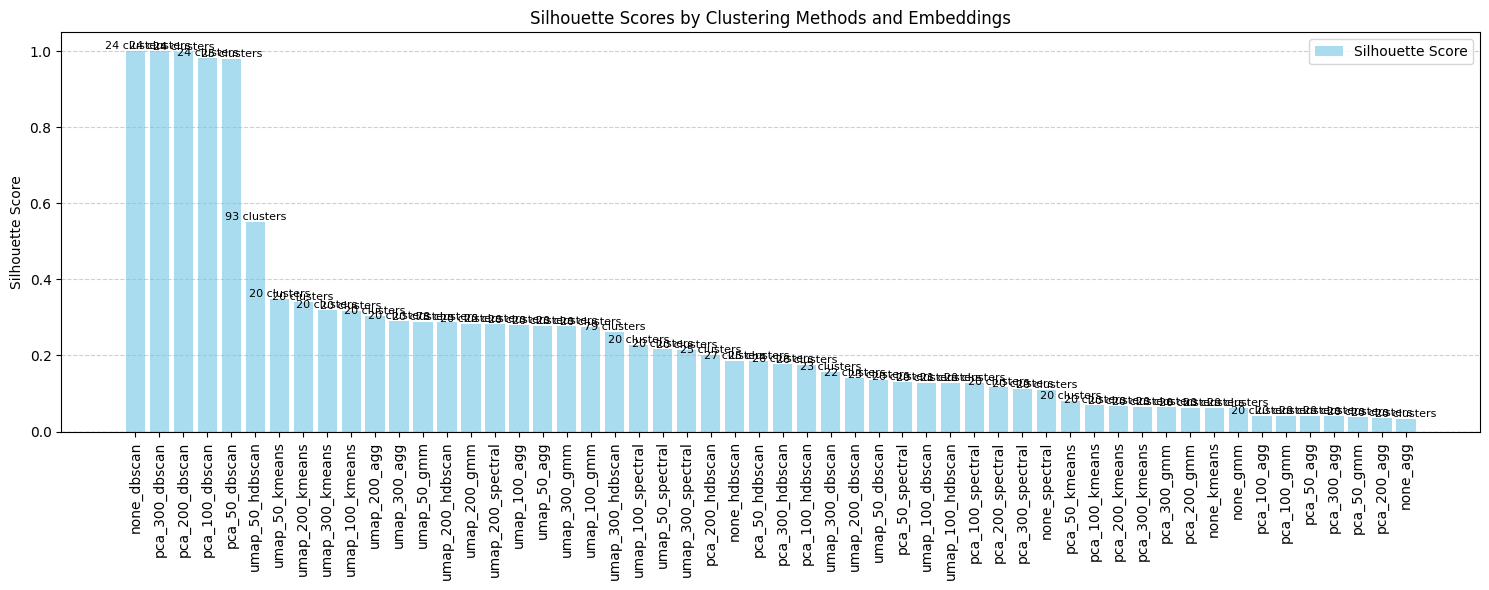

In [ ]:
import matplotlib.pyplot as plt

# Extracting data for visualization
methods = list(sorted_sil_scores.keys())
clusters = [v[0] for v in sorted_sil_scores.values()]
scores = [v[1] for v in sorted_sil_scores.values()]

# Convert invalid scores (-1) to NaN for better visualization
scores = [np.nan if s == -1 else s for s in scores]

# Visualization
plt.figure(figsize=(15, 6))

# Bar chart for silhouette scores
plt.bar(methods, scores, color='skyblue', alpha=0.7, label='Silhouette Score')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')

# Add cluster count as annotations
for i, (method, cluster_count) in enumerate(zip(methods, clusters)):
    plt.text(i, scores[i] if not np.isnan(scores[i]) else 0, 
             f"{cluster_count} clusters", 
             ha='center', va='bottom' if scores[i] >= 0 else 'top', fontsize=8)

# Customize the plot
plt.xticks(rotation=90, fontsize=10)
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores by Clustering Methods and Embeddings")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend()
plt.show()